In [1]:
# import required libraries for dataframe and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import altair as alt
from altair import datum
alt.data_transformers.disable_max_rows()
alt.data_transformers.enable('json')
# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score

In [2]:
df = pd.read_csv(r'D:\OnlineRetail.csv',encoding= 'unicode_escape')
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [3]:
def initial_eda(df):
    if isinstance(df, pd.DataFrame):
        total_na = df.isna().sum().sum()
        print("Dimensions : %d rows, %d columns" % (df.shape[0], df.shape[1]))
        print("Total NA Values : %d " % (total_na))
        print("%38s %10s     %10s %10s" % ("Column Name", "Data Type", "#Distinct", "NA Values"))
        col_name = df.columns
        dtyp = df.dtypes
        uniq = df.nunique()
        na_val = df.isna().sum()
        for i in range(len(df.columns)):
            print("%38s %10s   %10s %10s" % (col_name[i], dtyp[i], uniq[i], na_val[i]))
        
    else:
        print("Expect a DataFrame but got a %15s" % (type(df)))
initial_eda(df)

Dimensions : 541909 rows, 8 columns
Total NA Values : 136534 
                           Column Name  Data Type      #Distinct  NA Values
                             InvoiceNo     object        25900          0
                             StockCode     object         4070          0
                           Description     object         4223       1454
                              Quantity      int64          722          0
                           InvoiceDate     object        23260          0
                             UnitPrice    float64         1630          0
                            CustomerID    float64         4372     135080
                               Country     object           38          0


In [4]:
df.drop(columns='CustomerID').describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0


In [5]:
df= df[df.Quantity > 0]
df= df[df.UnitPrice > 0]
df.drop(columns='CustomerID').describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,530104.0,10.542037,155.524124,1.000,1.00,3.00,10.00,80995.00
UnitPrice,530104.0,3.907625,35.915681,0.001,1.25,2.08,4.13,13541.33


In [6]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     132220
Country             0
dtype: int64

In [7]:
df.dropna(inplace=True)
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [8]:
initial_eda(df)

Dimensions : 397884 rows, 8 columns
Total NA Values : 0 
                           Column Name  Data Type      #Distinct  NA Values
                             InvoiceNo     object        18532          0
                             StockCode     object         3665          0
                           Description     object         3877          0
                              Quantity      int64          301          0
                           InvoiceDate     object        17282          0
                             UnitPrice    float64          440          0
                            CustomerID    float64         4338          0
                               Country     object           37          0


### Data attribute information
- InvoiceNo: Invoice number 6-digit integral number, Object.
- StockCode: Product code 5-digit integral number, Object.
- Description: Product name, Object.
- Quantity: The quantities of each product per transaction, int64.
- InvoiceDate: Invice date and time, int64.
- UnitPrice: Unit price, int64.
- CustomerID: Customer number, Object.
- Country: Country name, Object.

In [9]:
# change the column names
df.rename(index=str, columns={'InvoiceNo': 'invoice_num',
                              'StockCode' : 'stock_code',
                              'Description' : 'description',
                              'Quantity' : 'quantity',
                              'InvoiceDate' : 'invoice_date',
                              'UnitPrice' : 'unit_price',
                              'CustomerID' : 'cust_id',
                              'Country' : 'country'}, inplace=True)
# change the invoice_date format - String to Timestamp format
df['invoice_date'] = pd.to_datetime(df.invoice_date, format='%d-%m-%Y %H:%M')
df['cust_id'] = df['cust_id'].astype('int64')
# change description - UPPER case to LOWER case
df['description'] = df.description.str.lower()
# Creating a new column in the dataframe for total price of a unit and rearranging the dataframe/dataset
df['amount_spent'] = df['quantity'] * df['unit_price']
df= df[['invoice_num','invoice_date','stock_code','description','quantity','unit_price','amount_spent','cust_id','country']]
df.head()

,invoice_num,invoice_date,stock_code,description,quantity,unit_price,amount_spent,cust_id,country
0,536365,2010-12-01 08:26:00,85123A,white hanging heart t-light holder,6,2.55,15.30,17850,United Kingdom
1,536365,2010-12-01 08:26:00,71053,white metal lantern,6,3.39,20.34,17850,United Kingdom
2,536365,2010-12-01 08:26:00,84406B,cream cupid hearts coat hanger,8,2.75,22.00,17850,United Kingdom
3,536365,2010-12-01 08:26:00,84029G,knitted union flag hot water bottle,6,3.39,20.34,17850,United Kingdom
4,536365,2010-12-01 08:26:00,84029E,red woolly hottie white heart.,6,3.39,20.34,17850,United Kingdom


In [10]:
df.insert(loc=2, column='year_month', value=df['invoice_date'].map(lambda x: 100*x.year + x.month))
df.insert(loc=3, column='month', value=df.invoice_date.dt.month)
# +1 to make Monday=1.....until Sunday=7
df.insert(loc=4, column='day', value=(df.invoice_date.dt.dayofweek)+1)
df.insert(loc=5, column='hour', value=df.invoice_date.dt.hour)
df.head()

,invoice_num,invoice_date,year_month,month,day,hour,stock_code,description,quantity,unit_price,amount_spent,cust_id,country
0,536365,2010-12-01 08:26:00,201012,12,3,8,85123A,white hanging heart t-light holder,6,2.55,15.30,17850,United Kingdom
1,536365,2010-12-01 08:26:00,201012,12,3,8,71053,white metal lantern,6,3.39,20.34,17850,United Kingdom
2,536365,2010-12-01 08:26:00,201012,12,3,8,84406B,cream cupid hearts coat hanger,8,2.75,22.00,17850,United Kingdom
3,536365,2010-12-01 08:26:00,201012,12,3,8,84029G,knitted union flag hot water bottle,6,3.39,20.34,17850,United Kingdom
4,536365,2010-12-01 08:26:00,201012,12,3,8,84029E,red woolly hottie white heart.,6,3.39,20.34,17850,United Kingdom


# Data Vizualization

#### Number of Orders for different Customers

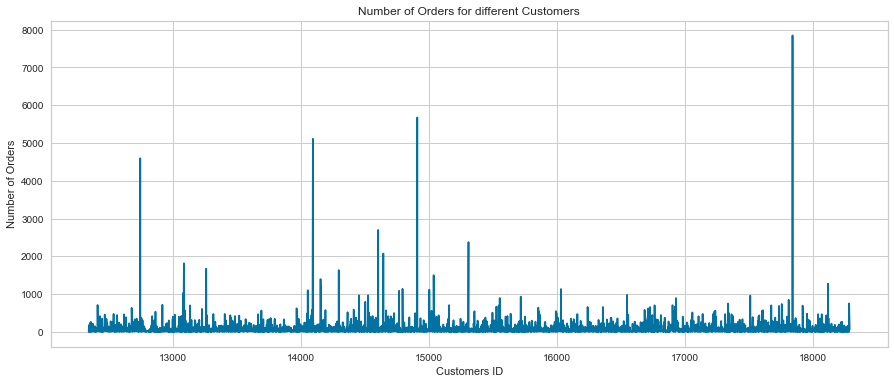

In [11]:
orders = df.groupby(by=['cust_id','country'], as_index=False)['invoice_num'].count()

plt.subplots(figsize=(15,6))
plt.plot(orders.cust_id, orders.invoice_num)
plt.xlabel('Customers ID')
plt.ylabel('Number of Orders')
plt.title('Number of Orders for different Customers')
plt.show()

In [12]:
print('The TOP 5 customers with most number of orders...')
orders.sort_values(by='invoice_num', ascending=False).head()

The TOP 5 customers with most number of orders...


,cust_id,country,invoice_num
4018,17841,United Kingdom,7847
1887,14911,EIRE,5675
1297,14096,United Kingdom,5111
334,12748,United Kingdom,4595
1669,14606,United Kingdom,2700


#### Money Spent for different Customers

From what you can see below you have the most money spent per customer but with this being shown there are more outliers given an a lower amount of data that is in a normal range you can see that when the amount spent goes over 50k you can detemine this to be an outlier. Lastly, when comparing the top 5 orders to top 5 money spent there is only one match and that is.
- 14911	EIRE with 5675 orders and $143,825.06 spent

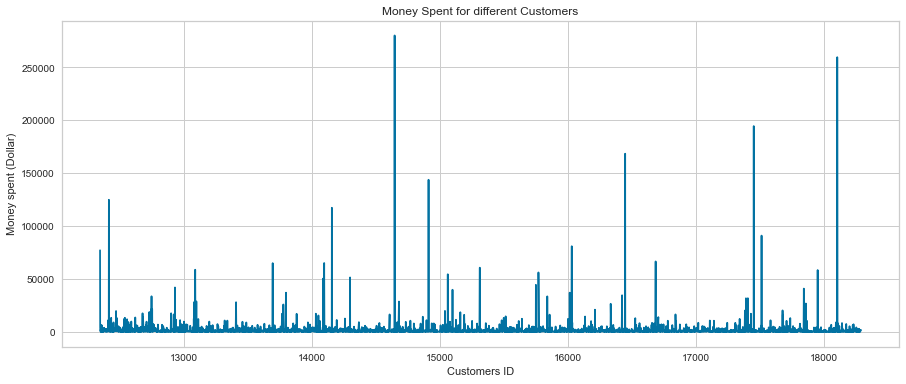

In [13]:
money_spent = df.groupby(by=['cust_id','country'], as_index=False)['amount_spent'].sum()

plt.subplots(figsize=(15,6))
plt.plot(money_spent.cust_id, money_spent.amount_spent)
plt.xlabel('Customers ID')
plt.ylabel('Money spent (Dollar)')
plt.title('Money Spent for different Customers')
plt.show()

In [14]:
print('The TOP 5 customers with highest money spent...')
money_spent.sort_values(by='amount_spent', ascending=False).head()

The TOP 5 customers with highest money spent...


,cust_id,country,amount_spent
1697,14646,Netherlands,280206.02
4209,18102,United Kingdom,259657.30
3736,17450,United Kingdom,194550.79
3016,16446,United Kingdom,168472.50
1887,14911,EIRE,143825.06


#### Number of orders for different Months (1st Dec 2010 - 9th Dec 2011)

Below you will see the number of orders that have been place from the 1st Dec 2010 - 9th Dec 2011. In the bar graph you can see that there is a trend occurring every 2 to 3 months where the number of orders are rising and failing. If there is more to investigate would to see why there is a consistent rise and fall in throughout the year. 

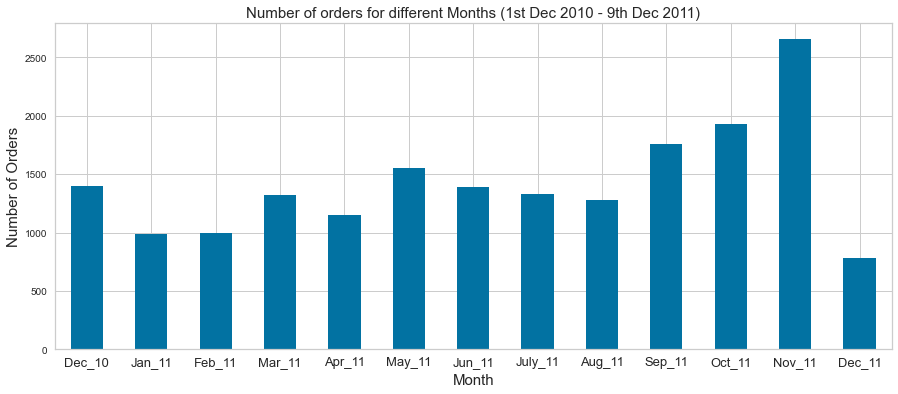

In [15]:
color = sns.color_palette()
ax = df.groupby('invoice_num')['year_month'].unique().value_counts().sort_index().plot(kind='bar',color=color[0],figsize=(15,6))
ax.set_xlabel('Month',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for different Months (1st Dec 2010 - 9th Dec 2011)',fontsize=15)
ax.set_xticklabels(('Dec_10','Jan_11','Feb_11','Mar_11','Apr_11','May_11','Jun_11','July_11','Aug_11','Sep_11','Oct_11','Nov_11','Dec_11'), rotation='horizontal', fontsize=13)
plt.show()

#### Number of orders for different Days

We can see here that the most popular day to order an item is on Thrusday. This can be useful to increase targeting customers before and during this day to increase it further or find out why that is so that we can bring up the weekend orders. 

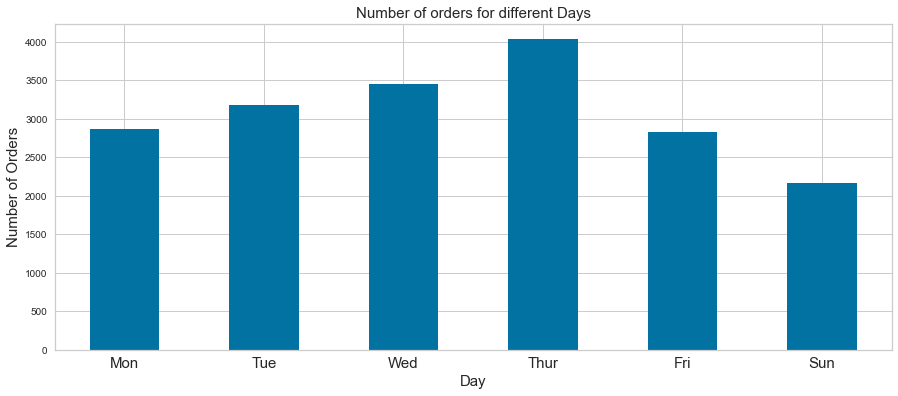

In [16]:
ax = df.groupby('invoice_num')['day'].unique().value_counts().sort_index().plot(kind='bar',color=color[0],figsize=(15,6))
ax.set_xlabel('Day',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for different Days',fontsize=15)
ax.set_xticklabels(('Mon','Tue','Wed','Thur','Fri','Sun'), rotation='horizontal', fontsize=15)
plt.show()

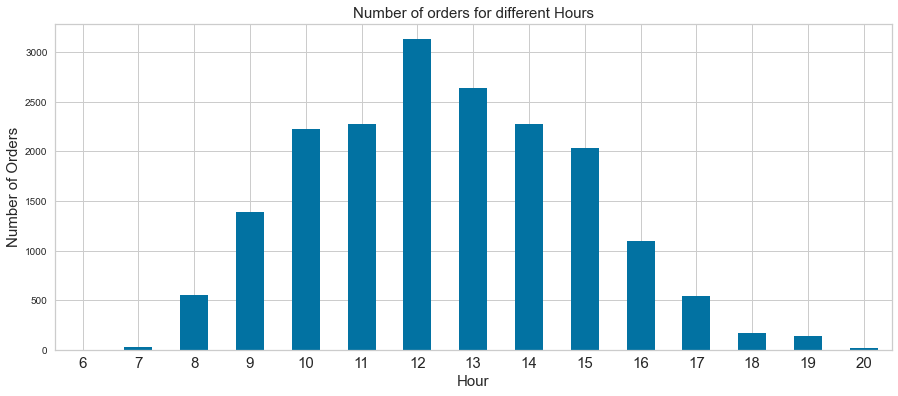

In [17]:
ax = df.groupby('invoice_num')['hour'].unique().value_counts().iloc[:-1].sort_index().plot(kind='bar',color=color[0],figsize=(15,6))
ax.set_xlabel('Hour',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for different Hours',fontsize=15)
ax.set_xticklabels(range(6,21), rotation='horizontal', fontsize=15)
plt.show()

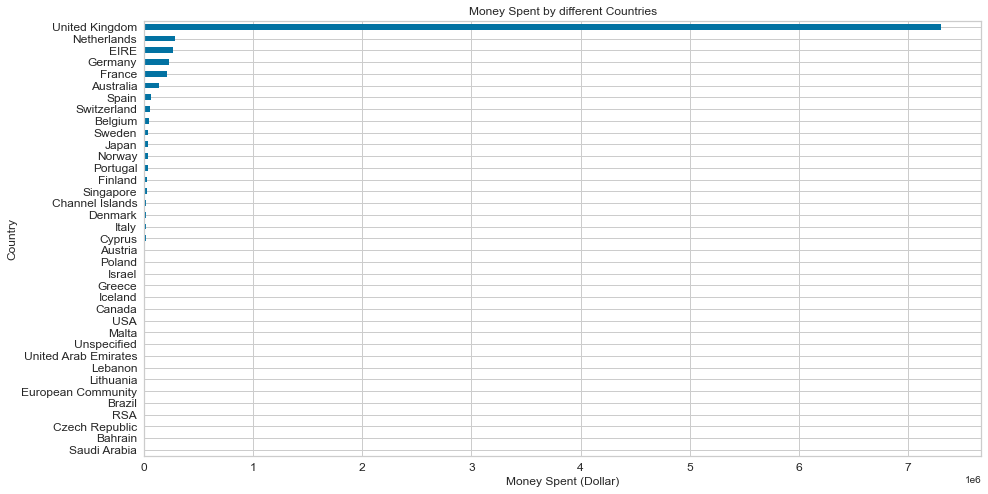

In [18]:
group_country_amount_spent = df.groupby('country')['amount_spent'].sum().sort_values()
# del group_country_orders['United Kingdom']

# plot total money spent by each country (with UK)
plt.subplots(figsize=(15,8))
group_country_amount_spent.plot(kind='barh', fontsize=12, color=color[0])
plt.xlabel('Money Spent (Dollar)', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Money Spent by different Countries', fontsize=12)
plt.show()

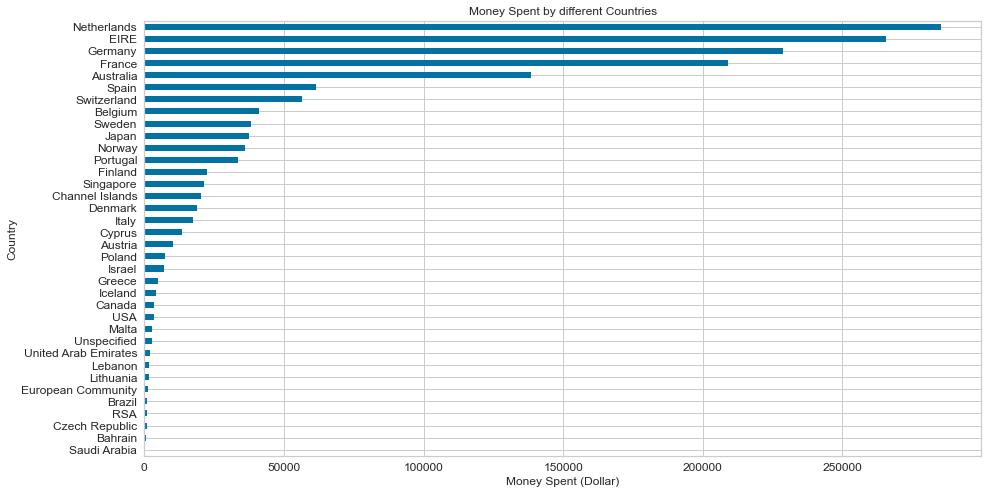

In [19]:
group_country_amount_spent = df.groupby('country')['amount_spent'].sum().sort_values()
del group_country_amount_spent['United Kingdom']

# plot total money spent by each country (without UK)
plt.subplots(figsize=(15,8))
group_country_amount_spent.plot(kind='barh', fontsize=12, color=color[0])
plt.xlabel('Money Spent (Dollar)', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Money Spent by different Countries', fontsize=12)
plt.show()

# Feature Engineering

In [20]:
df.head()

,invoice_num,invoice_date,year_month,month,day,hour,stock_code,description,quantity,unit_price,amount_spent,cust_id,country
0,536365,2010-12-01 08:26:00,201012,12,3,8,85123A,white hanging heart t-light holder,6,2.55,15.30,17850,United Kingdom
1,536365,2010-12-01 08:26:00,201012,12,3,8,71053,white metal lantern,6,3.39,20.34,17850,United Kingdom
2,536365,2010-12-01 08:26:00,201012,12,3,8,84406B,cream cupid hearts coat hanger,8,2.75,22.00,17850,United Kingdom
3,536365,2010-12-01 08:26:00,201012,12,3,8,84029G,knitted union flag hot water bottle,6,3.39,20.34,17850,United Kingdom
4,536365,2010-12-01 08:26:00,201012,12,3,8,84029E,red woolly hottie white heart.,6,3.39,20.34,17850,United Kingdom


In [21]:
# New Attribute : Monetary
df['Amount'] = df['quantity']*df['unit_price']
amount = df.groupby('cust_id')['Amount'].sum()
amount = amount.reset_index()
amount.head()

,cust_id,Amount
0,12346,77183.60
1,12347,4310.00
2,12348,1797.24
3,12349,1757.55
4,12350,334.40


In [22]:
# New Attribute : Frequency
Frequency = df.groupby('cust_id')['invoice_num'].count()
Frequency = Frequency.reset_index()
Frequency.columns = ['cust_id', 'Frequency']
Frequency.head()

,cust_id,Frequency
0,12346,1
1,12347,182
2,12348,31
3,12349,73
4,12350,17


In [23]:
AF = pd.merge(amount, Frequency, on='cust_id', how='inner')
AF.head()

,cust_id,Amount,Frequency
0,12346,77183.60,1
1,12347,4310.00,182
2,12348,1797.24,31
3,12349,1757.55,73
4,12350,334.40,17


In [24]:
# Compute the maximum date to know the last transaction date
max_date = max(df['invoice_date'])
max_date
df['Diff'] = max_date - df['invoice_date']
df.head()

,invoice_num,invoice_date,year_month,month,day,hour,stock_code,description,quantity,unit_price,amount_spent,cust_id,country,Amount,Diff
0,536365,2010-12-01 08:26:00,201012,12,3,8,85123A,white hanging heart t-light holder,6,2.55,15.30,17850,United Kingdom,15.30,373 days 04:24:00
1,536365,2010-12-01 08:26:00,201012,12,3,8,71053,white metal lantern,6,3.39,20.34,17850,United Kingdom,20.34,373 days 04:24:00
2,536365,2010-12-01 08:26:00,201012,12,3,8,84406B,cream cupid hearts coat hanger,8,2.75,22.00,17850,United Kingdom,22.00,373 days 04:24:00
3,536365,2010-12-01 08:26:00,201012,12,3,8,84029G,knitted union flag hot water bottle,6,3.39,20.34,17850,United Kingdom,20.34,373 days 04:24:00
4,536365,2010-12-01 08:26:00,201012,12,3,8,84029E,red woolly hottie white heart.,6,3.39,20.34,17850,United Kingdom,20.34,373 days 04:24:00


In [25]:
DaysSince = df.groupby('cust_id')['Diff'].min().dt.days
DaysSince = DaysSince.reset_index()
DaysSince.head()

,cust_id,Diff
0,12346,325
1,12347,1
2,12348,74
3,12349,18
4,12350,309


In [26]:
AFD = pd.merge(AF, DaysSince, on='cust_id', how='inner')
AFD.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
AFD.head()

,CustomerID,Amount,Frequency,Recency
0,12346,77183.60,1,325
1,12347,4310.00,182,1
2,12348,1797.24,31,74
3,12349,1757.55,73,18
4,12350,334.40,17,309


Text(0.5, 0, 'Attributes')

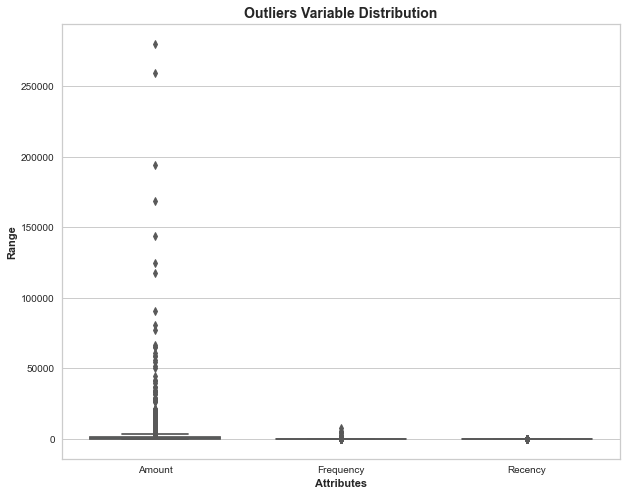

In [27]:
attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = AFD[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [28]:
# Removing (statistical) outliers for Amount
Q1 = AFD.Amount.quantile(0.05)
Q3 = AFD.Amount.quantile(0.95)
IQR = Q3 - Q1
AFD = AFD[(AFD.Amount >= Q1 - 1.5*IQR) & (AFD.Amount <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = AFD.Recency.quantile(0.05)
Q3 = AFD.Recency.quantile(0.95)
IQR = Q3 - Q1
AFD = AFD[(AFD.Recency >= Q1 - 1.5*IQR) & (AFD.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = AFD.Frequency.quantile(0.05)
Q3 = AFD.Frequency.quantile(0.95)
IQR = Q3 - Q1
AFD = AFD[(AFD.Frequency >= Q1 - 1.5*IQR) & (AFD.Frequency <= Q3 + 1.5*IQR)]

# Build the clustering models with comparison

In [29]:
AFD = AFD[['Amount', 'Frequency', 'Recency']]
# Instantiate
scaler = StandardScaler()
# fit_transform
AFD_scaled = scaler.fit_transform(AFD)
AFD_scaled.shape

(4256, 3)

In [30]:
AFD_scaled = pd.DataFrame(AFD_scaled)
AFD_scaled.columns = ['Amount', 'Frequency', 'Recency']
AFD_scaled.head()

,Amount,Frequency,Recency
0,1.645464,1.067693,-0.918021
1,0.261938,-0.460713,-0.189452
2,0.240085,-0.035593,-0.748354
3,-0.543502,-0.602419,2.155942
4,0.652204,0.085870,-0.578687


In [31]:
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(AFD_scaled)
kmeans.labels_

array([3, 0, 0, ..., 1, 0, 0])

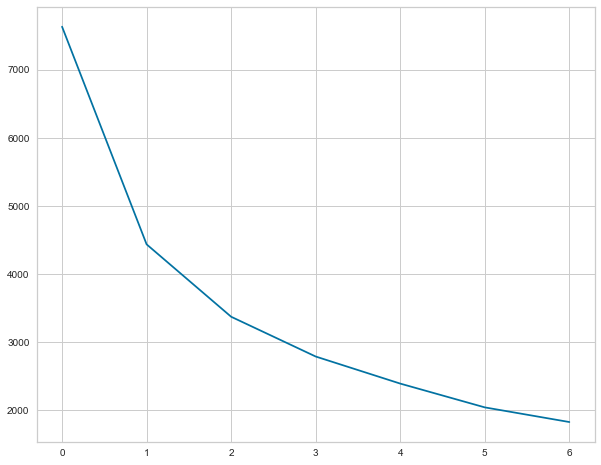

In [32]:
# Elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(AFD_scaled)
    ssd.append(kmeans.inertia_)
# plot the SSDs for each n_clusters
plt.plot(ssd)

In [33]:
k_means = KMeans(n_clusters= 3, init='k-means++', random_state=0).fit(AFD_scaled)
clusters = k_means.predict(AFD_scaled)
AFD['Cluster_Label'] = cl_labels_k = k_means.labels_
AFD.head()

,Amount,Frequency,Recency,Cluster_Label
1,4310.00,182,1,2
2,1797.24,31,74,0
3,1757.55,73,18,0
4,334.40,17,309,1
5,2506.04,85,35,0


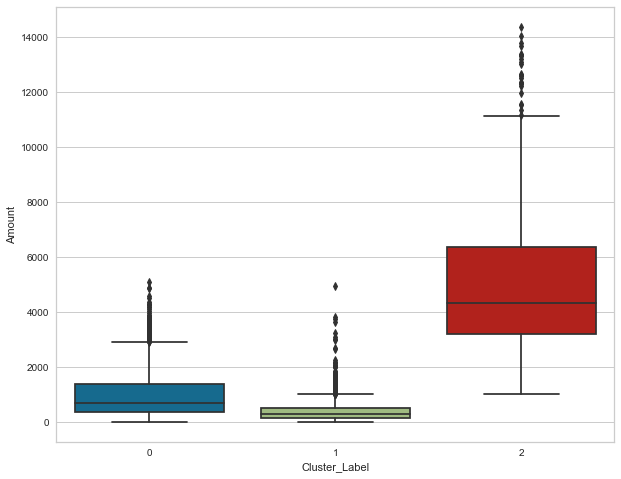

In [34]:
sns.boxplot(x='Cluster_Label', y='Amount', data=AFD)

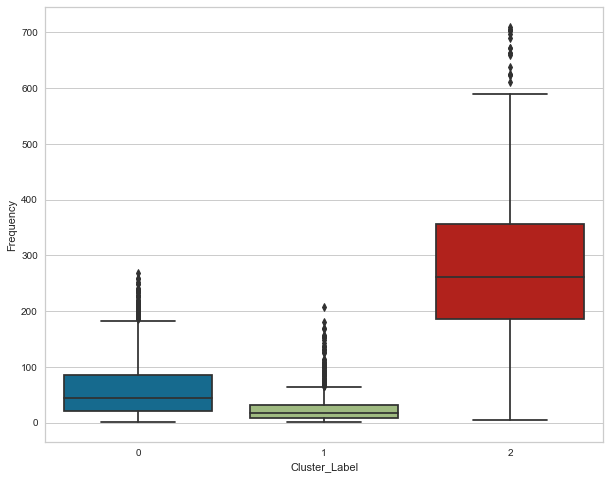

In [35]:
sns.boxplot(x='Cluster_Label', y='Frequency', data=AFD)

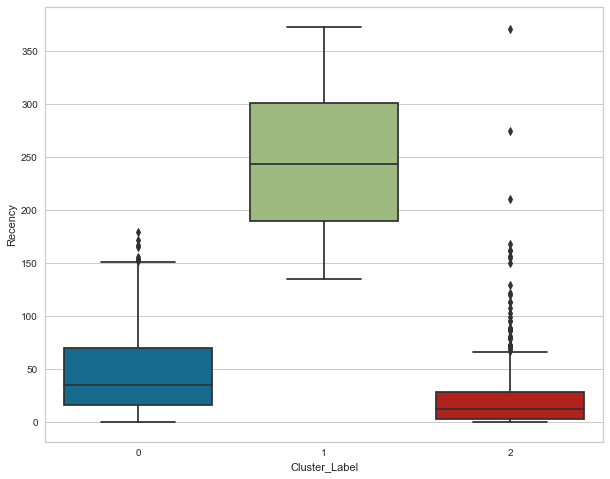

In [36]:
sns.boxplot(x='Cluster_Label', y='Recency', data=AFD)